# Phase 4 Project: Skin Condition Classification
## Technical Modeling Notebook
### Authored by Trinity Gahagen
---
---

This notebook and the modeling notebook both work with the Skin Condition image dataset found on this [Kaggle page](https://www.kaggle.com/datasets/syedalinaqvi/augmented-skin-conditions-image-dataset).

# Dataset Overview
The following description of the dataset was taken from the Kaggle page.

>Description:
>
>This dataset contains augmented images of six different dermatological conditions. Each category includes 399 images, providing a balanced >dataset ideal for training machine learning models, particularly in the field of medical image analysis.
>
>### Categories:
>Acne: A common skin condition that occurs when hair follicles become clogged with oil and dead skin cells, leading to pimples, blackheads, or whiteheads.
>
>Carcinoma: A type of skin cancer that begins in the basal or squamous cells. The images in this category may show various stages and forms of skin carcinoma.
>
>Eczema: A condition that makes the skin red, inflamed, itchy, and sometimes results in blisters. The images depict different manifestations of eczema.
>
>Keratosis: A skin condition characterized by rough, scaly patches on the skin caused by excessive growth of keratin. This category includes images of various types of keratosis, such as actinic keratosis.
>
>Milia: Small, white, benign bumps that typically appear on the face, especially around the eyes and on the cheeks. The images show different instances of this condition.
>
>Rosacea: A chronic skin condition that causes redness and visible blood vessels in your face. This category contains images depicting the typical characteristics of rosacea.
>
>
>### Dataset Details:
>Total Images: 2,394
>
>Images per Category: 399
>
>Image Format: JPEG
>
>Image Size: Variable.
>
>Augmentation Techniques: The images have been augmented using techniques such as rotation, flipping, zooming, and brightness adjustment to enhance the diversity of the dataset and improve model generalization.

# Basic Imports
---

In [7]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from glob import glob

# Plotting Tools
import colorcet as cc
from matplotlib.ticker import FuncFormatter

# Classical ML Models and Tools
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
# HOG tools
from skimage.feature import hog
from skimage import exposure

# Neural Network Models and Tools
from tensorflow.data import AUTOTUNE
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, SGD
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.data.experimental import cardinality
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential as SequentialLayer

In [26]:
PARENT_DIRECTORY = "../Skin_Conditions/"

# Classical ML Approach: Preprocessing Functions and Testing
---

In [49]:
# Create a bunch of functions to try and get this data in
def preprocess_image(image_path, r_height=200, r_width=200):
    # Read in image and convert to grayscale
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Resize to send into HOG feature extraction
    final_img = cv2.resize(gray, (r_width, r_height), interpolation=cv2.INTER_LINEAR)

    return final_img


def get_hog_features(image, orientations=9, ppc=(10, 10), cpb=(2,2), vis=True, norm_strat='L2-Hys'):
    # Perform HOG feature extraction on images
    return_list = hog(image=image,
                      orientations=orientations,
                      pixels_per_cell=ppc,
                      cells_per_block=cpb,
                      visualize=vis,
                      block_norm=norm_strat,
                      feature_vector=True)

    hog_features = return_list[0]
    if vis:
        hog_image = return_list[1]
        return hog_features, hog_image
    else:
        return hog_features

In [67]:
# Test out HOG function to see if it works
test_image = preprocess_image(os.path.join(PARENT_DIRECTORY, 'Acne/Acne_1.jpg'), r_height=200, r_width=200)

fd, hog_image = get_hog_features(test_image, orientations=8, vis=True, ppc=(10, 10))

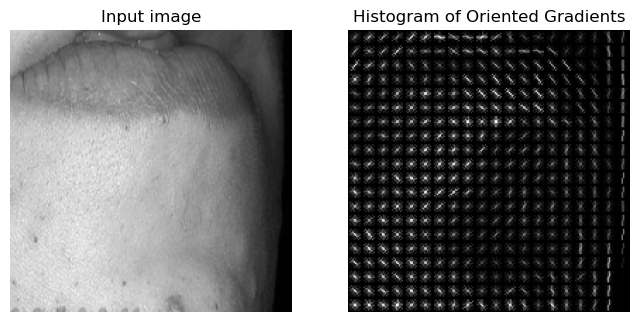

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(test_image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [69]:
print(test_image.shape)
print(len(fd))

(200, 200)
11552


Both functions apppear to work correctly; now it's time to create a dataset of HOG features and their labels in order to create, train, and test a machine learning classifier.

# Classical ML Approach
---

In [7]:
subdirectories = [os.path.join(PARENT_DIRECTORY, d) for d in os.listdir(PARENT_DIRECTORY) if os.path.isdir(os.path.join(PARENT_DIRECTORY, d))]
class_labels = [d for d in os.listdir(PARENT_DIRECTORY) if os.path.isdir(os.path.join(PARENT_DIRECTORY, d))]
display(subdirectories)
display(class_labels)

['../Skin_Conditions/Acne',
 '../Skin_Conditions/Carcinoma',
 '../Skin_Conditions/Eczema',
 '../Skin_Conditions/Keratosis',
 '../Skin_Conditions/Milia',
 '../Skin_Conditions/Rosacea']

['Acne', 'Carcinoma', 'Eczema', 'Keratosis', 'Milia', 'Rosacea']

In [8]:
try:
    hog_feature_dataset = pd.read_csv('hog_feature_dataset.csv')
except:
    X = []
    y = []

    for n in range(len(subdirectories)):
        image_paths = os.listdir(subdirectories[n])
        label = class_labels[n]

        for image_name in image_paths:
            image = preprocess_image(os.path.join(subdirectories[n], image_name), r_height=200, r_width=200)
            features, _ = get_hog_features(image, orientations=8, vis=True, ppc=(10, 10))
            X.append(features)
            y.append(label)
    
    X = np.array(X)
    y = np.array(y)

    hog_feature_dataset = pd.DataFrame(X)
    hog_feature_dataset['label'] = pd.Series(y)
    hog_feature_dataset.to_csv('hog_feature_dataset.csv')

In [9]:
hog_feature_dataset.shape

(2394, 11554)

In [11]:
hog_feature_dataset.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,11543,11544,11545,11546,11547,11548,11549,11550,11551,label
0,0,0.211348,0.166950,0.237940,0.119206,0.158945,0.091624,0.074846,0.111099,0.237940,...,0.197499,0.047109,0.000000,0.004759,0.000000,0.013460,0.000000,0.000000,0.000000,Acne
1,1,0.208728,0.114609,0.092877,0.119227,0.220190,0.053851,0.173592,0.178275,0.220190,...,0.081708,0.240606,0.086694,0.170505,0.193546,0.240606,0.033096,0.137859,0.071150,Acne
2,2,0.264206,0.089693,0.148965,0.005641,0.123901,0.053102,0.258255,0.264206,0.189894,...,0.144737,0.238052,0.020689,0.125748,0.091612,0.238052,0.224589,0.238052,0.238052,Acne
3,3,0.246354,0.108047,0.137881,0.125360,0.103154,0.096391,0.155473,0.246354,0.246354,...,0.200697,0.247021,0.089394,0.246352,0.000000,0.199447,0.031855,0.200203,0.074420,Acne
4,4,0.051676,0.125630,0.152512,0.221810,0.277385,0.043925,0.105411,0.013363,0.146065,...,0.062598,0.163810,0.073421,0.085935,0.130334,0.282411,0.211685,0.086246,0.027026,Acne


In [14]:
le = LabelEncoder()
X = hog_feature_dataset.drop(columns=['label'])
y = le.fit_transform(hog_feature_dataset['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size= 0.8,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)


In [123]:
shotgun_approach = {
    'knn' : {
        'model' : KNeighborsClassifier(),
        'score' : []
    },
    'svc' : {
        'model' : SVC(),
        'score' : []
    },
    'gboost' : {
        'model' : GradientBoostingClassifier(),
        'score' : []
    },
    'rand_forest' : {
        'model' : RandomForestClassifier(),
        'score' : []
    }
}


for model in shotgun_approach:
    classifier = shotgun_approach[model]['model']

    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)

    class_report = classification_report(y_test, y_pred)
    shotgun_approach[model]['score'].append(class_report)

In [137]:
# Save the output of this cell so that we don't need to re-run the previous cell
%%capture output

for model in shotgun_approach:
    print(f'Model Name: {model}')
    print('Classification Report:')
    print(shotgun_approach[model]["score"][0])
    print('----------------------------------------')

with open('shotgun_approach_output.txt', 'w') as file:
    file.write(output.stdout)

In [141]:
output.show()

Model Name: knn
Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.68      0.39        79
           1       0.29      0.39      0.33        80
           2       0.32      0.30      0.31        80
           3       0.55      0.20      0.29        80
           4       0.42      0.35      0.38        80
           5       0.86      0.07      0.14        80

    accuracy                           0.33       479
   macro avg       0.45      0.33      0.31       479
weighted avg       0.45      0.33      0.31       479

----------------------------------------
Model Name: svc
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.62      0.55        79
           1       0.53      0.69      0.60        80
           2       0.63      0.56      0.60        80
           3       0.57      0.53      0.55        80
           4       0.60      0.53      0.56        80
           5 

From the results above, unsurprisingly, the ensemble models performed the best. We will attempt to optimize these models, firstly by applying PCA to the dataset, to try and reduce the curse of dimensionality.

In [142]:
shotgun_approach_pca = {
    'gboost' : {
        'model' : GradientBoostingClassifier(),
        'score' : []
    },
    'rand_forest' : {
        'model' : RandomForestClassifier(),
        'score' : []
    }
}


for model in shotgun_approach_pca:
    classifier = shotgun_approach_pca[model]['model']
    pipeline = Pipeline(steps=[('pca', PCA(n_components=0.95)), ('classifier', classifier)])
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    class_report = classification_report(y_test, y_pred)
    shotgun_approach_pca[model]['score'].append(class_report)

In [144]:
for model in shotgun_approach_pca:
    print(f'Model Name: {model}')
    print('Classification Report:')
    print(shotgun_approach_pca[model]["score"][0])
    print('----------------------------------------')

Model Name: gboost
Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.61      0.46        79
           1       0.53      0.61      0.57        80
           2       0.62      0.50      0.55        80
           3       0.54      0.47      0.50        80
           4       0.56      0.44      0.49        80
           5       0.64      0.46      0.54        80

    accuracy                           0.52       479
   macro avg       0.54      0.52      0.52       479
weighted avg       0.54      0.52      0.52       479

----------------------------------------
Model Name: rand_forest
Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.75      0.44        79
           1       0.49      0.51      0.50        80
           2       0.62      0.38      0.47        80
           3       0.52      0.36      0.43        80
           4       0.64      0.47      0.55        80
  

PCA seemed to dramatically decrease the performance of both models. It may be worth investigating different HOG hyperparameters to see if changing the data itself will lead to an increase in performance.

In [16]:
# Let's try one more classifier, without PCA
nbc = GaussianNB()

nbc.fit(X_train, y_train)

y_pred = nbc.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.66      0.55        79
           1       0.33      0.55      0.41        80
           2       0.46      0.47      0.47        80
           3       0.43      0.28      0.34        80
           4       0.57      0.35      0.43        80
           5       0.60      0.39      0.47        80

    accuracy                           0.45       479
   macro avg       0.48      0.45      0.44       479
weighted avg       0.48      0.45      0.44       479



In [70]:
# Try different HOG feature hyperparameters on smaller batches of data to see the difference in performance
def small_batch_dataset(resize_shape=(200, 200), orientations=8, ppc=(10, 10), cpb=(2, 2), norm_strat='L2-Hys'):
    X = []
    y = []

    for n in range(len(subdirectories)):
        image_paths = os.listdir(subdirectories[n])[:50]
        label = class_labels[n]

        for image_name in image_paths:
            image = preprocess_image(os.path.join(subdirectories[n], image_name), r_height=resize_shape[1], r_width=resize_shape[0])
            features, _ = get_hog_features(image, orientations=orientations, vis=True, ppc=ppc, cpb=cpb, norm_strat=norm_strat)
            X.append(features)
            y.append(label)

    X = np.array(X)
    y = np.array(y)

    batch_df = pd.DataFrame(X)
    batch_df['label'] = pd.Series(y)

    return batch_df

In [71]:
def hog_hyperparameter_test(df):
    X = df.drop(columns=['label'])
    y = df['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        train_size=0.8,
                                                        test_size=0.2,
                                                        random_state=42,
                                                        stratify=y)

    model = GradientBoostingClassifier()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    return classification_report(y_test, y_pred)


**TESTING HYPERPARAMETERS: BASELINE**
- Image shape: (200, 200)
- Number of Orientations: 8
- Pixels per cell: (10, 10)
- Cells per block: (2, 2)
- Normalization strategy: L2-Hys

In [24]:
df = small_batch_dataset()
results = hog_hyperparameter_test(df)

print(results)

              precision    recall  f1-score   support

        Acne       0.22      0.20      0.21        10
   Carcinoma       0.00      0.00      0.00        10
      Eczema       0.83      0.50      0.62        10
   Keratosis       0.33      0.40      0.36        10
       Milia       0.50      0.50      0.50        10
     Rosacea       0.29      0.40      0.33        10

    accuracy                           0.33        60
   macro avg       0.36      0.33      0.34        60
weighted avg       0.36      0.33      0.34        60



In [25]:
df.shape

(300, 11553)

**TESTING HYPERPARAMETERS**
- Image shape: (100, 100)
- Number of Orientations: 8
- Pixels per cell: (5, 5)
- Cells per block: (2, 2)
- Normalization strategy: L2-Hys

In [26]:
df = small_batch_dataset(resize_shape=(100, 100), orientations=8, ppc=(5,5))
results = hog_hyperparameter_test(df)

print(results)

              precision    recall  f1-score   support

        Acne       0.20      0.20      0.20        10
   Carcinoma       0.08      0.10      0.09        10
      Eczema       0.25      0.40      0.31        10
   Keratosis       0.00      0.00      0.00        10
       Milia       0.20      0.20      0.20        10
     Rosacea       0.22      0.20      0.21        10

    accuracy                           0.18        60
   macro avg       0.16      0.18      0.17        60
weighted avg       0.16      0.18      0.17        60



**TESTING HYPERPARAMETERS**
- Image shape: (250, 250)
- Number of Orientations: 9
- Pixels per cell: (10, 10)
- Cells per block: (2, 2)
- Normalization strategy: L1

In [72]:
df = small_batch_dataset(resize_shape=(250, 250), orientations=9, ppc=(10,10), norm_strat='L1')
results = hog_hyperparameter_test(df)

print(results)

              precision    recall  f1-score   support

        Acne       0.27      0.30      0.29        10
   Carcinoma       0.22      0.20      0.21        10
      Eczema       0.70      0.70      0.70        10
   Keratosis       0.44      0.40      0.42        10
       Milia       0.56      0.50      0.53        10
     Rosacea       0.33      0.40      0.36        10

    accuracy                           0.42        60
   macro avg       0.42      0.42      0.42        60
weighted avg       0.42      0.42      0.42        60



**TESTING HYPERPARAMETERS**
- Image shape: (64, 128)
- Number of Orientations: 9
- Pixels per cell: (8, 8)
- Cells per block: (2, 2)
- Normalization strategy: L2-Hys

In [73]:
df = small_batch_dataset(resize_shape=(64, 128), orientations=9, ppc=(8,8), norm_strat='L2-Hys')
results = hog_hyperparameter_test(df)

print(results)

              precision    recall  f1-score   support

        Acne       0.42      0.50      0.45        10
   Carcinoma       0.43      0.30      0.35        10
      Eczema       0.31      0.50      0.38        10
   Keratosis       0.50      0.40      0.44        10
       Milia       0.62      0.50      0.56        10
     Rosacea       0.33      0.30      0.32        10

    accuracy                           0.42        60
   macro avg       0.44      0.42      0.42        60
weighted avg       0.44      0.42      0.42        60



**TESTING HYPERPARAMETERS**
- Image shape: (64, 128)
- Number of Orientations: 8
- Pixels per cell: (8, 8)
- Cells per block: (2, 2)
- Normalization strategy: L1

In [74]:
df = small_batch_dataset(resize_shape=(64, 128), orientations=8, ppc=(8,8), norm_strat='L1')
results = hog_hyperparameter_test(df)

print(results)

              precision    recall  f1-score   support

        Acne       0.40      0.20      0.27        10
   Carcinoma       0.07      0.10      0.08        10
      Eczema       0.44      0.40      0.42        10
   Keratosis       0.10      0.10      0.10        10
       Milia       0.45      0.50      0.48        10
     Rosacea       0.36      0.40      0.38        10

    accuracy                           0.28        60
   macro avg       0.31      0.28      0.29        60
weighted avg       0.31      0.28      0.29        60



**TESTING HYPERPARAMETERS**
- Image shape: (64, 128)
- Number of Orientations: 9
- Pixels per cell: (8, 8)
- Cells per block: (2, 2)
- Normalization strategy: L2

In [75]:
df = small_batch_dataset(resize_shape=(64, 128), orientations=9, ppc=(8,8), norm_strat='L2')
results = hog_hyperparameter_test(df)

print(results)

              precision    recall  f1-score   support

        Acne       0.46      0.60      0.52        10
   Carcinoma       0.25      0.20      0.22        10
      Eczema       0.06      0.10      0.08        10
   Keratosis       0.57      0.40      0.47        10
       Milia       0.33      0.40      0.36        10
     Rosacea       0.25      0.10      0.14        10

    accuracy                           0.30        60
   macro avg       0.32      0.30      0.30        60
weighted avg       0.32      0.30      0.30        60



In [76]:
df = small_batch_dataset(resize_shape=(128, 64), orientations=9, ppc=(8,8), norm_strat='L2-Hys')
results = hog_hyperparameter_test(df)

print(results)

              precision    recall  f1-score   support

        Acne       0.25      0.20      0.22        10
   Carcinoma       0.18      0.20      0.19        10
      Eczema       0.12      0.10      0.11        10
   Keratosis       0.75      0.60      0.67        10
       Milia       0.14      0.10      0.12        10
     Rosacea       0.33      0.60      0.43        10

    accuracy                           0.30        60
   macro avg       0.30      0.30      0.29        60
weighted avg       0.30      0.30      0.29        60



The data configuration that makes the classifier perform the best appears to be the standard hyperparameter values of:
- Image shape: (64, 128)
- Number of Orientations: 9
- Pixels per cell: (8, 8)
- Cells per block: (2, 2)
- Normalization strategy: L2-Hys

This configuration produced a 9% accuracy increase from the baseline, and had the most balanced F1 scores for each class.

Knowing this, we will now create a dataset configured to these values, tune the hyperparameters of the classifier itself, and see how high of an accuracy we can get.

In [77]:
try:
    hog_feature_dataset = pd.read_csv('optimal_hog_feature_dataset.csv')
except:
    X = []
    y = []

    for n in range(len(subdirectories)):
        image_paths = os.listdir(subdirectories[n])
        label = class_labels[n]

        for image_name in image_paths:
            image = preprocess_image(os.path.join(subdirectories[n], image_name), r_width=64, r_height=128)
            features, _ = get_hog_features(image, orientations=9, vis=True, ppc=(8, 8), norm_strat='L2-Hys')
            X.append(features)
            y.append(label)
    
    X = np.array(X)
    y = np.array(y)

    hog_feature_dataset = pd.DataFrame(X)
    hog_feature_dataset['label'] = pd.Series(y)
    hog_feature_dataset.to_csv('optimal_hog_feature_dataset.csv')

In [78]:
hog_feature_dataset.shape

(2394, 3781)

In [80]:
le = LabelEncoder()
X = hog_feature_dataset.drop(columns=['label'])
y = le.fit_transform(hog_feature_dataset['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

model_test = {
    'gboost' : {
        'model' : GradientBoostingClassifier(),
        'score' : []
    },
    'rand_forest' : {
        'model' : RandomForestClassifier(),
        'score' : []
    }
}


for model in model_test:
    classifier = model_test[model]['model']

    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)

    class_report = classification_report(y_test, y_pred)
    model_test[model]['score'].append(class_report)

In [82]:
for model in model_test:
    print(f'Model Name: {model}')
    print('Classification Report:')
    print(model_test[model]["score"][0])
    print('----------------------------------------')

Model Name: gboost
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.53      0.51        79
           1       0.60      0.66      0.63        80
           2       0.61      0.49      0.54        80
           3       0.56      0.59      0.57        80
           4       0.60      0.66      0.63        80
           5       0.66      0.56      0.61        80

    accuracy                           0.58       479
   macro avg       0.59      0.58      0.58       479
weighted avg       0.59      0.58      0.58       479

----------------------------------------
Model Name: rand_forest
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.59      0.51        79
           1       0.57      0.65      0.60        80
           2       0.63      0.47      0.54        80
           3       0.56      0.61      0.58        80
           4       0.52      0.50      0.51        80
  

The accuracies of both of the best-performant models from the initial dataset configuration have done *worse* with the current dataset configuration, despite seeing improvements in the tests on smaller datasets. We will try to tune the Gradient Boosting Classifier only a little bit further, but if this does not yield significant improvement, we will move onto a different approach: Neural Networks.

In [85]:
gb = GradientBoostingClassifier()

cv = StratifiedKFold(n_splits=6)

params = {
    'min_samples_split' : [20, 25],
    'max_depth' : [5, 10, 15],
    # 'min_samples_leaf' : [15, 25, 50]
}

results = GridSearchCV(estimator=gb, param_grid=params, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)

In [86]:
results.fit(X, y)

Fitting 6 folds for each of 6 candidates, totalling 36 fits


GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_split': [20, 25]},
             scoring='accuracy', verbose=1)

In [87]:
print(f"Best parameters: {results.best_params_}")
print(f"Best accuracy: {results.best_score_}")

Best parameters: {'max_depth': 5, 'min_samples_split': 20}
Best accuracy: 0.5847953216374269


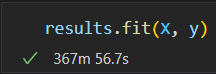

# Convolutional Neural Network Approach

In [37]:
IMAGE_HEIGHT = IMAGE_WIDTH = 84
batch_size = 32

In [38]:
training_data = image_dataset_from_directory(directory=PARENT_DIRECTORY,
                                          validation_split=0.25,
                                          label_mode='int',
                                          subset='training',
                                          seed=42,
                                          image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                          batch_size=batch_size)

validation_data = image_dataset_from_directory(directory=PARENT_DIRECTORY,
                                          validation_split=0.25,
                                          label_mode='int',
                                          subset='validation',
                                          seed=42,
                                          image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                          batch_size=batch_size)


val_batches = validation_data.cardinality().numpy()

print(val_batches)

test_data = validation_data.take((2*val_batches) // 5)
validation_data = validation_data.skip((2*val_batches) // 5)

print(validation_data.cardinality().numpy())

Found 2394 files belonging to 6 classes.
Using 1796 files for training.
Found 2394 files belonging to 6 classes.
Using 598 files for validation.
19
12


In [39]:
def configure_performant_datasets(dataset, shuffling=None):
    """ Custom function to prefetch and cache stored elements
    of retrieved image data to boost latency and performance
    at the cost of higher memory usage. """
    # Cache and prefetch elements of input data for boosted performance
    if not shuffling:
        return dataset.cache().prefetch(buffer_size=AUTOTUNE)
    else:
        return dataset.cache().shuffle(shuffling).prefetch(buffer_size=AUTOTUNE)
    
training_dataset = configure_performant_datasets(training_data,
                                                 shuffling=1796)
validation_dataset = configure_performant_datasets(validation_data)

In [40]:
Conv2D = layers.Conv2D
MaxPool2D = layers.MaxPooling2D
Dropout = layers.Dropout
Flatten = layers.Flatten
Dense = layers.Dense
GaussianNoise = layers.GaussianNoise
Rescaling = layers.Rescaling
RandomFlip = layers.RandomFlip

In [41]:
rescale = Rescaling(1./255, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

noise = GaussianNoise(0.1)

conv_1 = Conv2D(16,
                kernel_size=(3,3),
                padding='valid',
                strides=(1,1),
                activation='relu',
                input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

conv_2 = Conv2D(35,
                kernel_size=(3,3),
                padding='valid',
                strides=(1,1),
                activation='relu')

pooling_1 = MaxPool2D(pool_size=(2,2), strides=(1,1))

dropout_2 = Dropout(0.35)
flatten = Flatten()
fc_1 = Dense(25,
             activation='leaky_relu')
dropout_3 = Dropout(0.5)
output = Dense(6,
               activation = 'softmax')

c:\Users\twitt\anaconda3\envs\deep-learn-env\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\twitt\anaconda3\envs\deep-learn-env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
horizontal_flip = RandomFlip("horizontal",
                                          input_shape=(IMAGE_HEIGHT,
                                                       IMAGE_WIDTH,
                                                       3))

In [43]:
model = Sequential()

model.add(horizontal_flip)
model.add(noise)
model.add(rescale)
model.add(conv_1)
model.add(conv_2)
model.add(pooling_1)
model.add(dropout_2)
model.add(flatten)
model.add(fc_1)
model.add(dropout_3)
model.add(output)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_3 (RandomFlip)      │ (None, 84, 84, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_3                │ (None, 84, 84, 3)      │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 84, 84, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 82, 82, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 80, 80, 35)     │         5,075 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 79, 79, 35)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 79, 79, 35)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 218435)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │     5,460,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,466,579 (20.85 MB)

 Trainable params: 5,466,579 (20.85 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
optimizer = Adam(0.0001)

model.compile(optimizer=optimizer,
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# callback = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, verbose=1)

epochs, batch_size = 20, 16

In [45]:
history = model.fit(training_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.1932 - loss: 1.9459 - val_accuracy: 0.3583 - val_loss: 1.5677
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.3357 - loss: 1.6306 - val_accuracy: 0.4572 - val_loss: 1.4427
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.4381 - loss: 1.4388 - val_accuracy: 0.5160 - val_loss: 1.3139
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.5176 - loss: 1.3230 - val_accuracy: 0.5668 - val_loss: 1.2145
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.5724 - loss: 1.2099 - val_accuracy: 0.5561 - val_loss: 1.1961
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.5908 - loss: 1.1532 - val_accuracy: 0.5936 - val_loss: 1.1527
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - accuracy: 0.6236 - loss: 1.0970 - val_accuracy: 0.6203 - val_loss: 1.1096
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.6054 - loss: 1.0710 - val_accuracy: 0

In [46]:
model.evaluate(test_data)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7175 - loss: 0.9092


[0.9591372609138489, 0.6919642686843872]

# External Resources
---
https://selfdriving5.github.io/udacity/Self-Driving%20Car%20Engineer%20v5.0.0(us)/Part%2003-Module%2001-Lesson%2001_Object%20Detection/20.%20scikit-image%20HOG.html

https://machinelearningmastery.com/opencv_hog/

https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.hog

https://medium.com/swlh/histogram-of-oriented-gradients-hog-for-multiclass-image-classification-and-image-recommendation-cf0ea2caaae8

https://customers.pyimagesearch.com/lesson-sample-histogram-of-oriented-gradients-and-car-logo-recognition/